In [ ]:
import numpy as np
from utils import *
import pandas as pd
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,roc_curve, auc
from sklearn.preprocessing import label_binarize
import os, math
from pathlib import Path
from tqdm import tqdm
from skimage.feature import hessian_matrix_det
from skimage.feature import blob_dog, blob_doh
from skimage.filters import difference_of_gaussians

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bundle = get_features(in_imgs = None, feat_name = 'complex',joblib_path = 'complex_feat_testing.joblib', return_bundle= True)

Loaded: X=(1311, 768), y=(1311,), paths=1311
Class counts: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}
Mismatches: 0
'glioma' indices sample: [0, 1, 2, 3, 4]


In [ ]:
X_train_comp, y_train_comp = bundle.X, bundle.y

In [ ]:
paths = bundle.paths

In [ ]:
df = pd.DataFrame({
    "feat_vec": [x for x in bundle.X],
    "target": bundle.y.tolist(),
    "filepath": bundle.paths
})

In [ ]:
df.isna().sum()

,0
feat_vec,0
target,0
filepath,0
feat_canny,0
feat_dog,0
feat_doh,0


# Getting all the feats on a single df

In [ ]:
BASE_DIR = Path("/content/drive/MyDrive/281_final_project/standardized_data").resolve()

In [ ]:
def to_full_path(rel_path: str) -> str:
    #"/Training/glioma/Tr-gliTr_0000.jpg"
    rel = rel_path.lstrip("/")
    return str((BASE_DIR / rel).resolve())

In [ ]:
full_paths = df["filepath"].map(to_full_path).tolist()

In [ ]:
def load_img(path: str) -> np.ndarray:
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    return img

In [ ]:
def load_batches(paths, batch_size=64):
    N = len(paths)
    for start in range(0, N, batch_size):
        chunk = paths[start:start+batch_size]
        imgs = []
        miss_idx = []
        for j, p in enumerate(chunk):
          imgs.append(load_img(p))
        arr = np.stack(imgs, axis=0)  # (B, H, W)
        yield start, start+len(chunk), arr, miss_idx

In [ ]:
N = len(full_paths)
feat_canny = [None] * N
feat_dog   = [None] * N
feat_doh   = [None] * N

BATCH = 64

In [ ]:
N

1311

In [ ]:
for s, e, arr, miss_idx in tqdm(load_batches(full_paths, BATCH), total=math.ceil(N/BATCH), desc="Extracting all features"):
    # Each call returns np.array with one row per image in the batch
    canny_batch = get_features(arr, feat_name="canny")
    dog_batch   = get_features(arr, feat_name="blob_dog")
    doh_batch   = get_features(arr, feat_name="blob_doh")

    # Assign back per item
    for i in range(e - s):
        feat_canny[s + i] = canny_batch[i]
        feat_dog[s + i]   = dog_batch[i]
        feat_doh[s + i]   = doh_batch[i]

Extracting all features: 100%|██████████| 21/21 [40:25<00:00, 115.50s/it]


In [ ]:
df["feat_canny"] = feat_canny
df["feat_dog"]   = feat_dog
df["feat_doh"]   = feat_doh

In [ ]:
save_path = "/content/drive/MyDrive/281_final_project/aligned_testing_features.csv"
df.to_csv(save_path, index=False)

In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,feat_vec,target,filepath
0,"[0.4638672, 0.06591797, 0.1161499, -0.42871094...",1,/Training/meningioma/Tr-me_0379.jpg
1,"[0.70214844, 0.82177734, 0.001953125, -0.62792...",2,/Training/notumor/Tr-no_0609.jpg
2,"[0.4428711, 0.98339844, 0.54589844, -0.5219726...",0,/Training/glioma/Tr-gl_0561.jpg
3,"[0.36694336, 0.8828125, 0.08862305, -0.3208007...",3,/Training/pituitary/Tr-pi_1210.jpg
4,"[0.15002441, 0.91796875, 0.06262207, -0.346679...",3,/Training/pituitary/Tr-pi_1205.jpg
...,...,...,...
5707,"[1.578125, 1.1074219, -0.018310547, -0.5913086...",2,/Training/notumor/Tr-no_1112.jpg
5708,"[0.73535156, 0.7324219, -0.24804688, -0.357910...",3,/Training/pituitary/Tr-pi_0936.jpg
5709,"[0.7285156, 0.5957031, -0.3935547, -0.48413086...",3,/Training/pituitary/Tr-pi_0971.jpg
5710,"[0.52441406, 0.74121094, 0.28955078, -0.964355...",3,/Training/pituitary/Tr-pi_1135.jpg


In [ ]:
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42, stratify=df["target"])

In [ ]:
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp["target"])

In [ ]:
X_train = np.stack(df_train["feat_vec"].values)
y_train = df_train["target"].values
X_val = np.stack(df_val["feat_vec"].values)
y_val = df_val["target"].values
X_test = np.stack(df_test["feat_vec"].values)
y_test = df_test["target"].values

In [ ]:
print(len(X_train),len(X_test),len(X_val))

4569 572 571


In [ ]:
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

Linear SVM


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Validation Accuracy: 0.9527145359019265
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       132
           1       0.92      0.88      0.90       134
           2       0.98      0.99      0.98       159
           3       0.97      0.97      0.97       146

    accuracy                           0.95       571
   macro avg       0.95      0.95      0.95       571
weighted avg       0.95      0.95      0.95       571

Test Accuracy: 0.9702797202797203
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       132
           1       0.97      0.91      0.94       134
           2       0.99      1.00      0.99       160
           3       0.99      0.99      0.99       146

    accuracy                           0.97       572
   macro avg       0.97      0.97      0.97       572
weighted avg       0.97      0.97      0.97       572



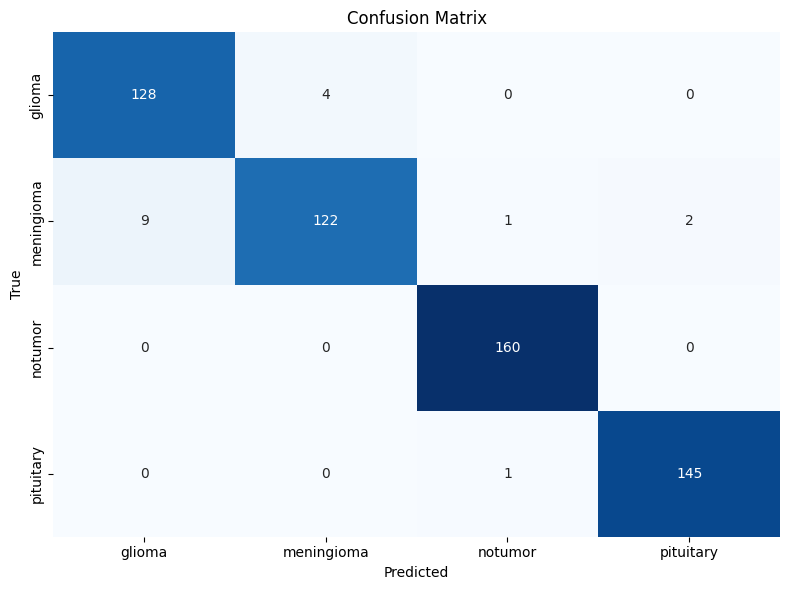

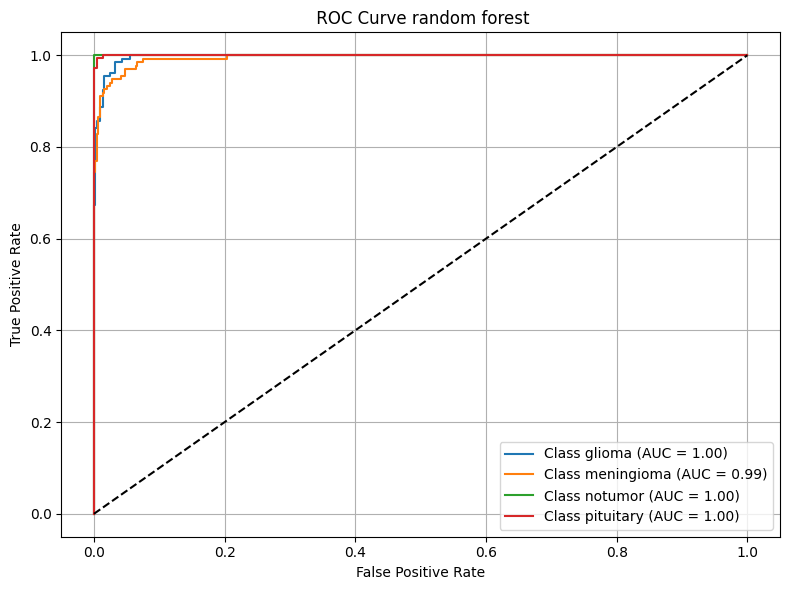

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, max_iter=1000, random_state=42))
clf.fit(X_train, y_train)
#val set
y_pred_val = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

#test set
y_pred_test = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))



cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[bundle.id2label[i] for i in sorted(set(y_test))],
            yticklabels=[bundle.id2label[i] for i in sorted(set(y_test))])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


y_score_clf = clf.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_clf[:, i])
    plt.plot(fpr, tpr, label=f"Class {bundle.id2label[classes[i]]} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(" ROC Curve random forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Non Linear SVM

Validation Accuracy: 0.9457092819614711
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       132
           1       0.87      0.91      0.89       134
           2       0.96      0.99      0.98       159
           3       0.97      0.98      0.97       146

    accuracy                           0.95       571
   macro avg       0.95      0.94      0.94       571
weighted avg       0.95      0.95      0.95       571

Test Accuracy: 0.9685314685314685
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       132
           1       0.92      0.95      0.93       134
           2       0.99      0.99      0.99       160
           3       0.99      0.99      0.99       146

    accuracy                           0.97       572
   macro avg       0.97      0.97      0.97       572
weighted avg       0.97      0.97      0.97       572



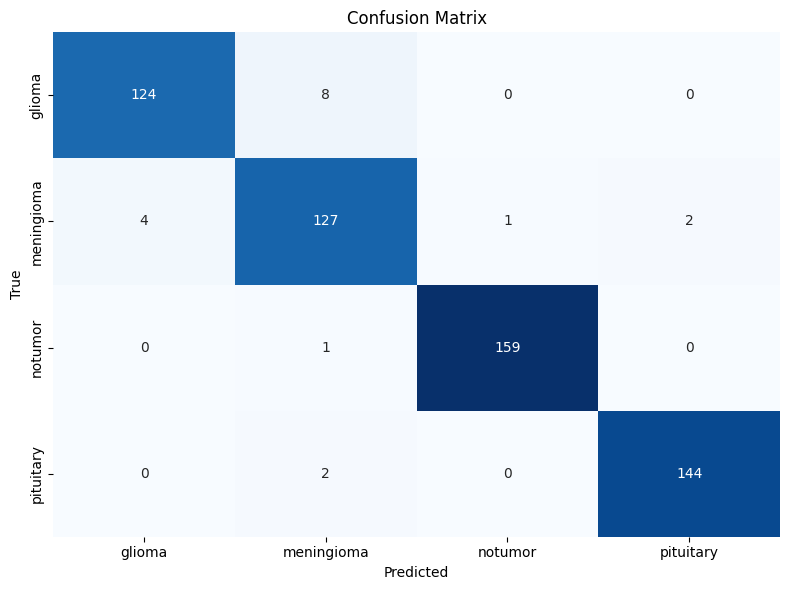

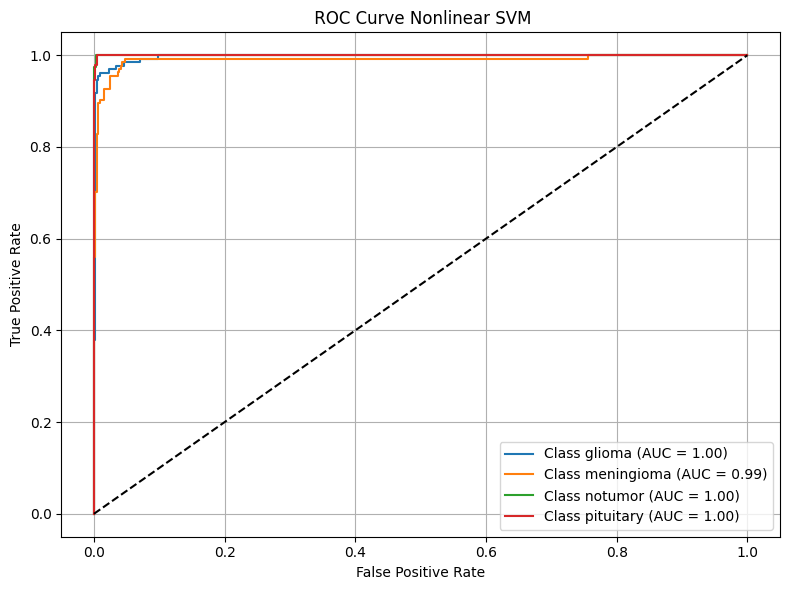

In [ ]:
rbf_svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))
rbf_svm.fit(X_train, y_train)

#val set
y_pred_rbf_val = rbf_svm.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_rbf_val))
print(classification_report(y_val, y_pred_rbf_val))

#test set
y_pred_rbf_test = rbf_svm.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_rbf_test))
print(classification_report(y_test, y_pred_rbf_test))



cm2 = confusion_matrix(y_test, y_pred_rbf_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[bundle.id2label[i] for i in sorted(set(y_test))],
            yticklabels=[bundle.id2label[i] for i in sorted(set(y_test))])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


y_score_rbfsvm = rbf_svm.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_rbfsvm[:, i])
    plt.plot(fpr, tpr, label=f"Class {bundle.id2label[classes[i]]} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(" ROC Curve Nonlinear SVM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Random Forest

Random Forest Val Accuracy: 0.9001751313485113
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       132
           1       0.82      0.84      0.83       134
           2       0.95      0.94      0.94       159
           3       0.87      0.98      0.92       146

    accuracy                           0.90       571
   macro avg       0.90      0.90      0.90       571
weighted avg       0.90      0.90      0.90       571

Random Forest Test Accuracy: 0.9125874125874126
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       132
           1       0.83      0.87      0.85       134
           2       0.99      0.96      0.98       160
           3       0.88      0.99      0.93       146

    accuracy                           0.91       572
   macro avg       0.91      0.91      0.91       572
weighted avg       0.92      0.91      0.91       572



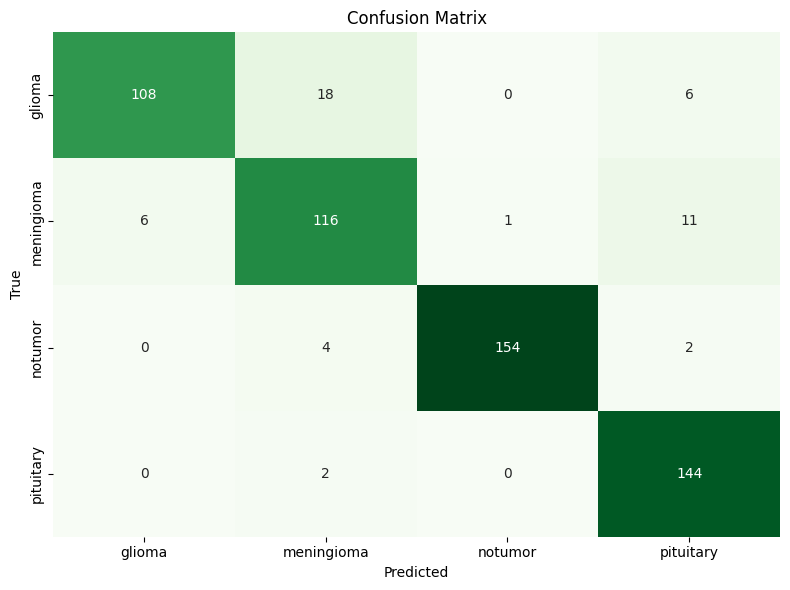

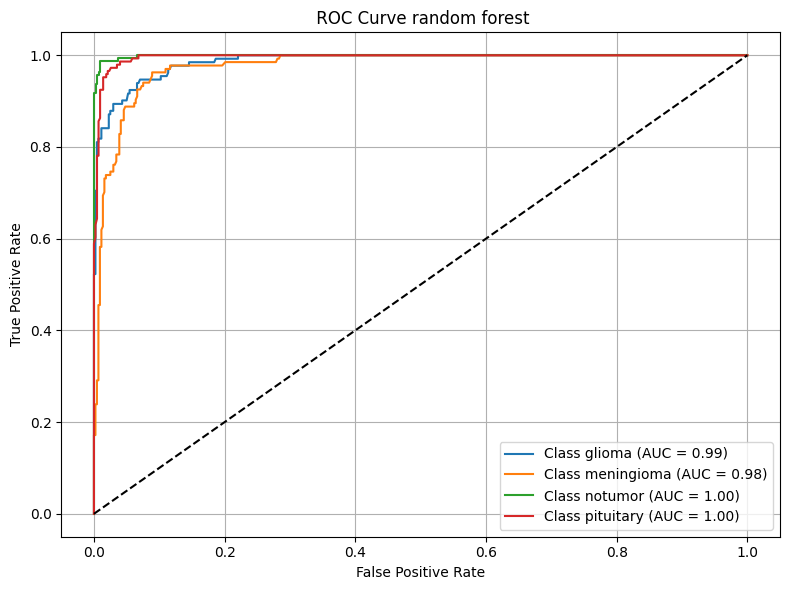

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=42)
rf.fit(X_train, y_train)


y_pred_rf_val = rf.predict(X_val)
print("Random Forest Val Accuracy:", accuracy_score(y_val, y_pred_rf_val))
print(classification_report(y_val, y_pred_rf_val))

y_pred_rf_test = rf.predict(X_test)
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf_test))
print(classification_report(y_test, y_pred_rf_test))


cm3 = confusion_matrix(y_test, y_pred_rf_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=[bundle.id2label[i] for i in sorted(set(y_test))],
            yticklabels=[bundle.id2label[i] for i in sorted(set(y_test))])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


y_score_rf = rf.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    plt.plot(fpr, tpr, label=f"Class {bundle.id2label[classes[i]]} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(" ROC Curve random forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:46:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Val Accuracy: 0.9281961471103327
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       132
           1       0.85      0.89      0.87       134
           2       0.97      0.98      0.97       159
           3       0.94      0.99      0.96       146

    accuracy                           0.93       571
   macro avg       0.93      0.92      0.92       571
weighted avg       0.93      0.93      0.93       571

XGBoost Test Accuracy: 0.9562937062937062
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       132
           1       0.91      0.93      0.92       134
           2       0.99      0.99      0.99       160
           3       0.95      0.99      0.97       146

    accuracy                           0.96       572
   macro avg       0.96      0.95      0.95       572
weighted avg       0.96      0.96      0.96       572



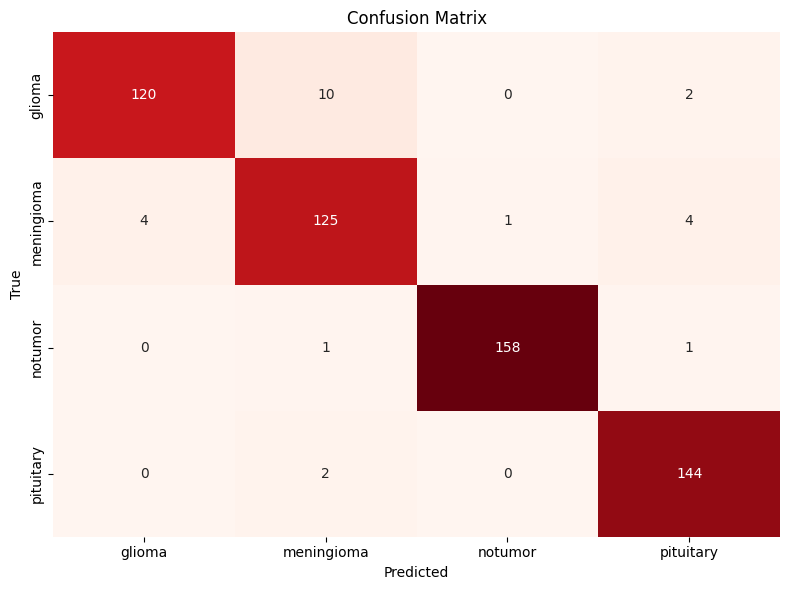

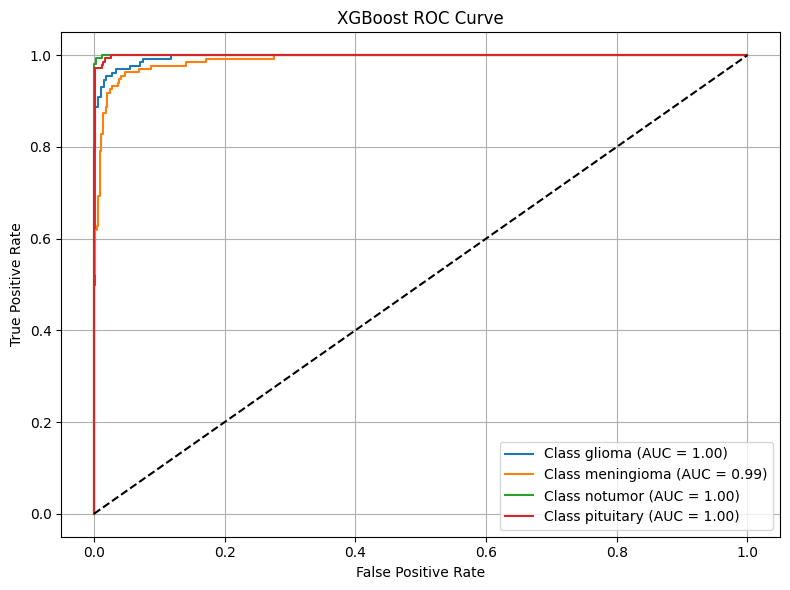

In [ ]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_clf.fit(X_train, y_train)


y_pred_xgb_val = xgb_clf.predict(X_val)
print("XGBoost Val Accuracy:", accuracy_score(y_val, y_pred_xgb_val))
print(classification_report(y_val, y_pred_xgb_val))

y_pred_xgb_test = xgb_clf.predict(X_test)
print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb_test))
print(classification_report(y_test, y_pred_xgb_test))



cm4 = confusion_matrix(y_test, y_pred_xgb_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm4, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=[bundle.id2label[i] for i in sorted(set(y_test))],
            yticklabels=[bundle.id2label[i] for i in sorted(set(y_test))])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


#ROC
y_score_xgb = xgb_clf.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_xgb[:, i])
    plt.plot(fpr, tpr, label=f"Class {bundle.id2label[classes[i]]} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logreg Val Accuracy: 0.9387040280210157
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       132
           1       0.91      0.85      0.88       134
           2       0.97      0.97      0.97       159
           3       0.94      0.98      0.96       146

    accuracy                           0.94       571
   macro avg       0.94      0.94      0.94       571
weighted avg       0.94      0.94      0.94       571

Logreg Test Accuracy: 0.9632867132867133
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       132
           1       0.95      0.90      0.92       134
           2       0.98      1.00      0.99       160
           3       0.97      0.99      0.98       146

    accuracy                           0.96       572
   macro avg       0.96      0.96      0.96       572
weighted avg       0.96      0.96      0.96       572



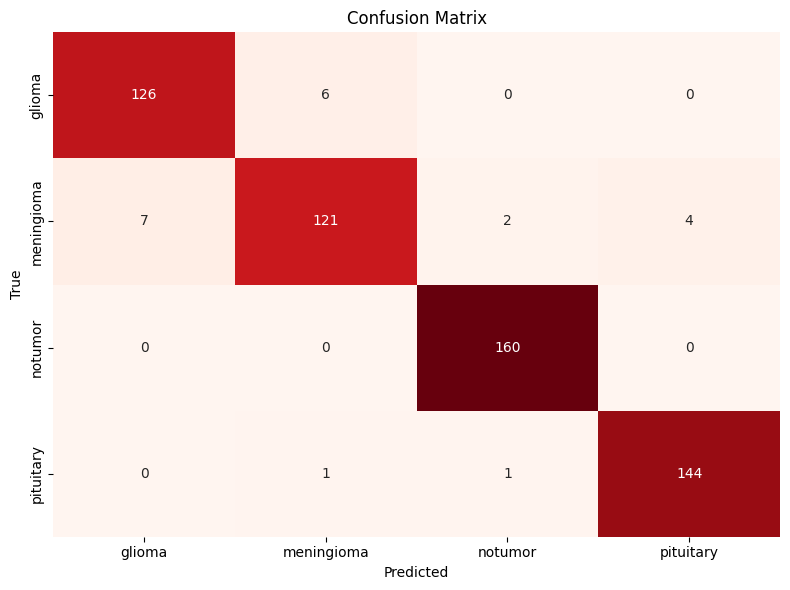

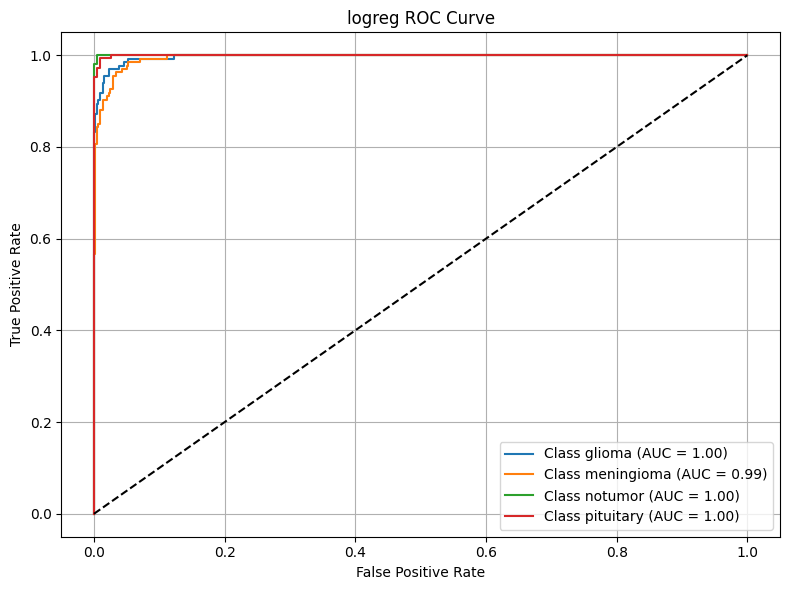

In [ ]:
logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, random_state=42)
)

logreg.fit(X_train, y_train)


y_pred_logreg_val = logreg.predict(X_val)
print("Logreg Val Accuracy:", accuracy_score(y_val, y_pred_logreg_val))
print(classification_report(y_val, y_pred_logreg_val))

y_pred_logreg_test = logreg.predict(X_test)
print("Logreg Test Accuracy:", accuracy_score(y_test, y_pred_logreg_test))
print(classification_report(y_test,  y_pred_logreg_test))



cm5 = confusion_matrix(y_test, y_pred_logreg_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm5, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=[bundle.id2label[i] for i in sorted(set(y_test))],
            yticklabels=[bundle.id2label[i] for i in sorted(set(y_test))])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


#ROC
y_score_logreg = logreg.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_logreg[:, i])
    plt.plot(fpr, tpr, label=f"Class {bundle.id2label[classes[i]]} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("logreg ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ensemble

In [ ]:
# Linear SVM
linear_svm = make_pipeline(
    StandardScaler(),
    LinearSVC(max_iter=1000, random_state=42)
)

# RBF SVM
rbf_svm = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', probability=True, random_state=42)
)

# Random Forest
rf = RandomForestClassifier(n_estimators=1000, random_state=42)

# XGBoost
xgb_clf = xgb.XGBClassifier(n_estimators=1000, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

Stack Val Accuracy: 0.9387040280210157
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       132
           1       0.91      0.85      0.88       134
           2       0.97      0.97      0.97       159
           3       0.94      0.98      0.96       146

    accuracy                           0.94       571
   macro avg       0.94      0.94      0.94       571
weighted avg       0.94      0.94      0.94       571

Stack Test Accuracy: 0.9755244755244755
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       132
           1       0.94      0.96      0.95       134
           2       0.99      1.00      1.00       160
           3       0.99      0.99      0.99       146

    accuracy                           0.98       572
   macro avg       0.97      0.97      0.97       572
weighted avg       0.98      0.98      0.98       572



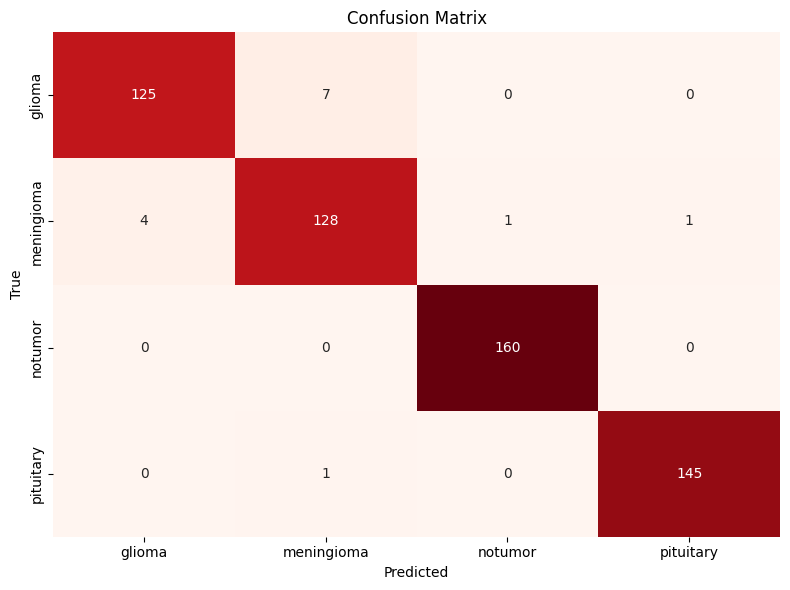

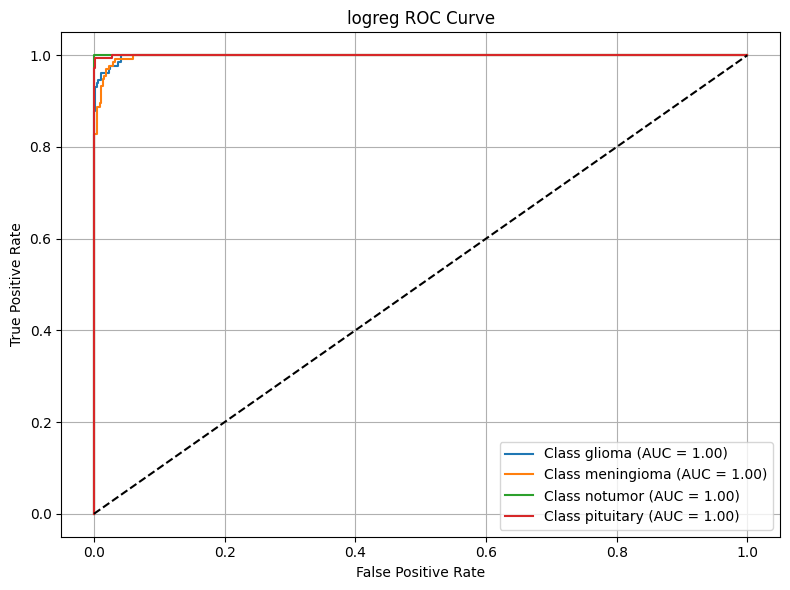

In [ ]:
meta_model = LogisticRegression(max_iter=1000, random_state=42)

stack_ensemble = StackingClassifier(
    estimators=[
        ('linear_svm', make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, random_state=42))),
        ('rbf_svm', rbf_svm),
        ('rf', rf),
        ('xgb', xgb_clf),
    ],
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

stack_ensemble.fit(X_train, y_train)


y_pred_stack_val = logreg.predict(X_val)
print("Stack Val Accuracy:", accuracy_score(y_val, y_pred_stack_val))
print(classification_report(y_val, y_pred_stack_val))

y_pred_stack_test = stack_ensemble.predict(X_test)
print("Stack Test Accuracy:", accuracy_score(y_test, y_pred_stack_test ))
print(classification_report(y_test, y_pred_stack_test ))




cm6 = confusion_matrix(y_test, y_pred_stack_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm6, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=[bundle.id2label[i] for i in sorted(set(y_test))],
            yticklabels=[bundle.id2label[i] for i in sorted(set(y_test))])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

#ROC
y_score_stack = stack_ensemble.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_stack[:, i])
    plt.plot(fpr, tpr, label=f"Class {bundle.id2label[classes[i]]} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("logreg ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Summary

print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf_test))
print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb_test))
print("Logreg Test Accuracy:", accuracy_score(y_test, y_pred_logreg_test))
print("Non linear SVM Test Accuracy:", accuracy_score(y_test, y_pred_rbf_test))
print("Linear SVM Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Stack Test Accuracy:", accuracy_score(y_test, y_pred_stack_test ))

Random Forest Test Accuracy: 0.9125874125874126
XGBoost Test Accuracy: 0.9562937062937062
Logreg Test Accuracy: 0.9632867132867133
Non linear SVM Test Accuracy: 0.9685314685314685
Linear SVM Test Accuracy: 0.9702797202797203
Stack Test Accuracy: 0.9755244755244755


# Ensemble for Our feats

In [ ]:
np.random.seed(42)

X_comp = np.stack(df["comp_vec"].values)
X_canny = np.stack(df["canny_vec"].values)
X_dog = np.stack(df["dog_vec"].values)
X_doh = np.stack(df["doh_vec"].values)
y = df["target"].values

# First split
X_comp_train, X_comp_temp, \
X_canny_train, X_canny_temp, \
X_dog_train, X_dog_temp, \
X_doh_train, X_doh_temp, \
y_train, y_temp = train_test_split(X_comp, X_canny, X_dog, X_doh, y,test_size=0.3, random_state=42, stratify=y)

# Val split
X_comp_val, X_comp_test, \
X_canny_val, X_canny_test, \
X_dog_val, X_dog_test, \
X_doh_val, X_doh_test, \
y_val, y_test = train_test_split(X_comp_temp, X_canny_temp, X_dog_temp, X_doh_temp, y_temp,test_size=0.7, random_state=42, stratify=y_temp)

In [ ]:
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

## Train base models

Canny x LogReg

In [ ]:
canny_mod = LogisticRegression(max_iter=1000).fit(X_dog_train, y_train)
canny_mod.fit(X_canny_train, y_train)
canny_val_probs = canny_mod.predict_proba(X_dog_val)

Complex x Linear SVM

In [ ]:
comp_mod = SVC(kernel='linear', probability=True, max_iter=1000, random_state=42))
comp_mod.fit(X_comp_train, y_train)
comp_val_probs = comp_mod.predict_proba(X_comp_val)

### combine probabilities

In [ ]:
X_combined_val = np.hstack([canny_val_probs, comp_val_probs]) #Add any other combos if we test more

In [ ]:
ens_model = LogisticRegression(max_iter=1000).fit(X_combined_val, y_val)

## Eval

In [ ]:
comp_test_probs = comp_mod.predict_proba(X_comp_test)
canny_test_probs = canny_mod.predict_proba(X_canny_test)

In [ ]:
X_combined_test = np.hstack([canny_test_probs, comp_test_probs])
y_pred = ens_model.predict(X_combined_test)
y_score = ens_model.predict_proba(X_combined_test)

In [ ]:
print("Stacked Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=[bundle.id2label[i] for i in classes],
            yticklabels=[bundle.id2label[i] for i in classes])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Ensemble Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {bundle.id2label[classes[i]]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()